#  Find peaks co-accessible with SOX10 and visualization

In [1]:
import sys
sys.path.append('../Scarp/')
import heapq
from downstream import *
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = sc.read_h5ad('../Exp1_Benchmark/Processed data/Sox10KD.h5ad')
sc.pp.filter_genes(data, min_cells=1)

In [3]:
peak_mat = pd.read_csv('./Results/SOX10_SCARP_Peaks_feature.csv', index_col=0)
peak_mat.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature31,feature32,feature33,feature34,feature35,feature36,feature37,feature38,feature39,feature40
chr1:10075-10487,-0.855688,0.052102,-0.081981,0.054011,0.238521,-0.010746,0.054127,-0.014001,0.083179,0.035954,...,-0.001874,0.021799,0.035144,-0.011831,0.018407,-0.084959,-0.104028,0.013439,-0.040513,0.015667
chr1:521416-521691,-0.766076,-0.018884,-0.028262,0.067060,0.291164,-0.028292,-0.041215,-0.012977,0.181066,0.081434,...,-0.179985,0.044385,-0.147663,-0.259744,-0.033782,0.038903,0.022074,-0.027792,0.112354,-0.024801
chr1:566322-566948,-0.955324,-0.012844,-0.074472,0.027287,-0.019501,0.072749,0.000369,-0.007287,0.125717,0.078298,...,0.072277,-0.027271,0.000830,0.022683,0.020322,0.002361,-0.071511,-0.012158,-0.033260,0.009100
chr1:567914-568188,-0.966981,-0.021671,-0.005806,-0.025828,-0.060871,0.009969,0.001565,-0.001564,0.102070,0.098103,...,0.066581,-0.053753,0.039218,0.013645,-0.038589,0.035987,-0.074875,-0.003216,-0.013210,-0.005968
chr1:569543-570212,-0.949795,-0.024210,0.064367,0.007924,-0.078252,0.056993,0.001907,0.001695,0.044280,0.012996,...,0.049294,-0.042556,-0.007618,0.012003,-0.026767,0.006704,-0.050977,0.027117,-0.035998,0.048932


##  filter peaks co-accessible with the promoter of SOX10

In [4]:
SOX10_corr_promoter = [np.corrcoef(peak_mat.loc['chr22:38380499-38380726'], peak_mat.iloc[i, :])[0, 1] 
                       for i in range(peak_mat.shape[0])]
SOX10_promoter_index = heapq.nlargest(10, range(len(SOX10_corr_promoter)), SOX10_corr_promoter.__getitem__)
diff_access_sites_promoter = peak_mat.iloc[SOX10_promoter_index, :].index

## filter peaks co-accessible with the 3'UTR of SOX10

In [5]:
SOX10_corr_3UTR = [np.corrcoef(peak_mat.loc['chr22:38364975-38365257'], peak_mat.iloc[i, :])[0, 1] 
                   for i in range(peak_mat.shape[0])]
SOX10_3UTR_index = heapq.nlargest(10, range(len(SOX10_corr_3UTR)), SOX10_corr_3UTR.__getitem__)
diff_access_sites_3UTR = peak_mat.iloc[SOX10_3UTR_index, :].index

## filter peaks co-accessible with SOX10

In [6]:
diff_access_sites = np.hstack([np.array(diff_access_sites_promoter),
                               np.array(diff_access_sites_3UTR)])

## Visualize accessibility of top 10 peaks

In [7]:
data.X = (data.X > 0) * 1
data_df = pd.DataFrame(np.array(data.X.todense()),
                       index=data.obs_names,
                       columns=data.var_names)
data_df = data_df[peak_mat.index]

In [8]:
data1 = sc.AnnData(data_df)
data1.var_names_make_unique()
data1.obs['celltype'] = data.obs['celltype']

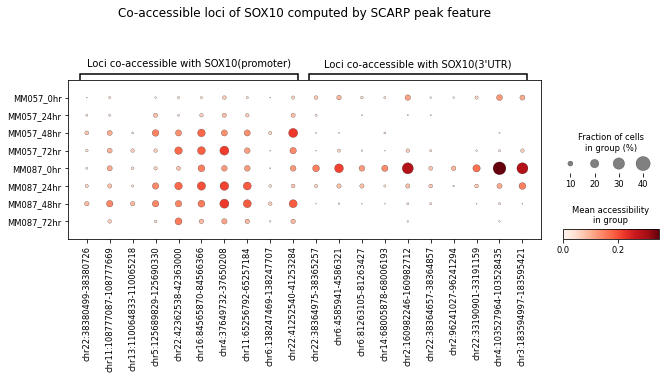

In [10]:
fig1, ax = plt.subplots(figsize=(10, 5))
plt.subplots_adjust(left=0.13, right=0.95, top=1, bottom=0.4)
dp = sc.pl.dotplot(data1, {'Loci co-accessible with SOX10(promoter)':
                           diff_access_sites[:10],
                           'Loci co-accessible with SOX10(3\'UTR)':
                               diff_access_sites[10:]},
                   groupby='celltype', var_group_rotation=0,
                   colorbar_title='Mean accessibility\nin group',
                   title='Co-accessible loci of SOX10 computed by SCARP peak feature',
                   ax=ax,
                   save='Co-accessible loci of SOX10 by SCARP.svg'
                  )

## Load the annotated information of peaks

In [11]:
annotation = pd.read_table('./Processed data/annotated_genes_1000bp.csv', sep=',', index_col=0)
annotation['peak_name'] = [annotation['seqnames'].iloc[i] + ':' +
                           str(annotation['start'].iloc[i] - 1) +
                           '-' + str(annotation['end'].iloc[i])
                           for i in range(annotation.shape[0])]
annotation.index = annotation['peak_name']
annotation

,seqnames,start,end,width,strand,annotation,geneChr,geneStart,geneEnd,geneLength,geneStrand,geneId,transcriptId,distanceToTSS,ENSEMBL,SYMBOL,GENENAME,peak_name
peak_name,,,,,,,,,,,,,,,,,,
chr1:713845-714384,chr1,713846,714384,539,*,Promoter,1,700245,714068,13824,2,100288069,uc001abo.3,0,NaN,LOC100288069,uncharacterized LOC100288069,chr1:713845-714384
chr1:762740-763106,chr1,762741,763106,366,*,Promoter,1,761586,762902,1317,2,79854,uc010nxx.2,0,ENSG00000225880,LINC00115,long intergenic non-protein coding RNA 115,chr1:762740-763106
chr1:860206-860406,chr1,860207,860406,200,*,Promoter,1,860530,871276,10747,1,148398,uc001abv.1,-124,ENSG00000187634,SAMD11,sterile alpha motif domain containing 11,chr1:860206-860406
chr1:873623-873915,chr1,873624,873915,292,*,Promoter,1,874655,879533,4879,1,148398,uc031pko.1,-740,ENSG00000187634,SAMD11,sterile alpha motif domain containing 11,chr1:873623-873915
chr1:877060-877260,chr1,877061,877260,200,*,Promoter,1,876524,879961,3438,1,148398,uc031pkp.1,537,ENSG00000187634,SAMD11,sterile alpha motif domain containing 11,chr1:877060-877260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrX:154299377-154299768,chrX,154299378,154299768,391,*,Promoter,23,154289900,154299547,9648,2,100272147,uc004fmy.3,0,ENSG00000182712,CMC4,C-X9-C motif containing 4,chrX:154299377-154299768
chrX:154444473-154444898,chrX,154444474,154444898,425,*,Promoter,23,154444701,154468098,23398,1,7411,uc004fnc.3,0,ENSG00000155959,VBP1,VHL binding protein 1,chrX:154444473-154444898
chrX:154493667-154493867,chrX,154493668,154493867,200,*,Promoter,23,154487526,154493852,6327,2,116442,uc004fne.3,0,ENSG00000155961,RAB39B,"RAB39B, member RAS oncogene family",chrX:154493667-154493867


##  save Top 50 that annotated as the promoter of some genes

In [12]:
SOX10_corr_df = pd.DataFrame({'corr_promoter': SOX10_corr_promoter,
                             'corr_3UTR':SOX10_corr_3UTR},
                             index = peak_mat.index)
SOX10_corr_df

,corr_promoter,corr_3UTR
chr1:10075-10487,0.839387,0.622219
chr1:521416-521691,0.767406,0.597039
chr1:566322-566948,0.891199,0.803088
chr1:567914-568188,0.901219,0.827049
chr1:569543-570212,0.883618,0.775084
...,...,...
chrY:58855117-58855317,0.357043,0.315766
chrY:58972911-58973157,0.586986,0.432717
chrY:58985014-58985249,0.707819,0.548271
chrY:58993942-58994142,0.724546,0.585412


In [13]:
SOX10_corr_df = SOX10_corr_df.loc[annotation.index]
SOX10_corr_df['gene'] = annotation['SYMBOL']
SOX10_corr_df['ENSEMBL'] = annotation['ENSEMBL']
SOX10_corr_df = SOX10_corr_df.dropna(how='any')
SOX10_corr_df

,corr_promoter,corr_3UTR,gene,ENSEMBL
peak_name,,,,
chr1:762740-763106,0.691432,0.513798,LINC00115,ENSG00000225880
chr1:860206-860406,0.334163,0.367789,SAMD11,ENSG00000187634
chr1:873623-873915,0.912930,0.841455,SAMD11,ENSG00000187634
chr1:877060-877260,0.887454,0.779652,SAMD11,ENSG00000187634
chr1:894546-894777,0.762400,0.689191,NOC2L,ENSG00000188976
...,...,...,...,...
chrX:154299377-154299768,0.708499,0.601831,CMC4,ENSG00000182712
chrX:154444473-154444898,0.915345,0.769797,VBP1,ENSG00000155959
chrX:154493667-154493867,0.735768,0.556473,RAB39B,ENSG00000155961


In [14]:
keep_genes_num = 51  # 有重复的基因，选51个去重完以后正好50个
diff_access_sites_df = SOX10_corr_df.loc[
    SOX10_corr_df.loc[:, ['corr_promoter', 'corr_3UTR']].to_numpy().max(axis=1) > 
    np.quantile(SOX10_corr_df['corr_promoter'].append(SOX10_corr_df['corr_3UTR']), 
                1-keep_genes_num/(2*SOX10_corr_df.shape[0])), :]
diff_access_sites_df

,corr_promoter,corr_3UTR,gene,ENSEMBL
peak_name,,,,
chr1:26218924-26219317,0.953420,0.694698,STMN1,ENSG00000117632
chr1:64239457-64239863,0.955103,0.648359,ROR1,ENSG00000185483
chr1:155830186-155830491,0.957251,0.762558,SYT11,ENSG00000132718
chr1:205144551-205144926,0.958655,0.745043,DSTYK,ENSG00000133059
chr1:207494475-207495185,0.957291,0.750348,CD55,ENSG00000196352
chr2:44776064-44776652,0.958294,0.798099,MIR548AD,ENSG00000265301
chr2:113032813-113033267,0.953098,0.758872,ZC3H6,ENSG00000188177
chr2:170334790-170335198,0.829874,0.956726,KLHL41,ENSG00000239474
chr2:172290396-172291230,0.956831,0.758464,METTL8,ENSG00000123600


In [15]:
diff_access_sites_df.to_csv('./Results/SCARP_diff_access_sites_top50.csv')